# **Customers Segmentation : R-F-M Segmentation**
*This notebook include building the K-Mean model for customers segmentation.*

## 1. Setup: Libraries & Database Connection
Import all necessary libraries and establish our connection to the analytics database.

In [30]:
# Import the necessary library
# Import  data
import sqlalchemy as db
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv 

# Manipulating the data
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import json

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.cm as cm

# Machine Learning Libraries 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Save the Model for Pipeline 
import joblib

warnings.filterwarnings(action = 'ignore')

In [2]:
# Access the Database 
# Load and get credentials from the environment 
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name_analysis = os.getenv("DB_ANALYTICS")

# Connection string
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_analysis}"

# Create SQLAlchemy engine 
try:
    engine = db.create_engine(connection_string)
    print(f"Connection to '{db_name_analysis}' successful.")
except Exception as e: 
    print(f"Connection failed: {e}")

# Create a connection to the Database
conn = engine.connect()

# Test query 
test_query = "SELECT * FROM dim_customers LIMIT 5;"
df_test = pd.read_sql(test_query, conn)
        
print("Test query successful:")
display(df_test)

Connection to 'db_olist_analytics' successful.
Test query successful:


,customer_id,customer_sk,customer_unique_id,customer_unique_sk,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,1,248ffe10d632bebe4f7267f1f44844c9,1,41016,Covington,Kentucky
1,000161a058600d5901f007fab4c27140,2,b0015e09bb4b6e47c52844fab5fb6638,2,10546,Millwood,New York
2,0001fd6190edaaf884bcaf3d49edf079,3,94b11d37cd61cb2994a194d11f89682b,3,62279,Renault,Illinois
3,0002414f95344307404f0ace7a26f1d5,4,4893ad4ea28b2c5b3ddf4e82e79db9e6,4,04742,Fort Fairfield,Maine
4,000379cdec625522490c315e70c7a9fb,5,0b83f73b19c2019e182fd552c048a22c,5,41016,Covington,Kentucky


## 2. Query for Analysis 

- **Recency (R)**: This measures the time elapsed since a customer's last purchase. It is a primary indicator of current engagement and churn risk. A customer who bought last week is more likely to be receptive to marketing than one who has not purchased in a year. It is calculated as the number of days between a fixed "analysis date" and the customer's most recent order date. Lower values are better.
    - For this analysis, the "snapshot" day is determined as the lastest day in the dataset.
- **Frequency (F)**: This measures the total number of purchases a customer has made over a given period. It is a direct indicator of customer loyalty and satisfaction. A customer who buys repeatedly has found value in the platform. It is calculated as the count of unique orders for each customer. Higher values are better.   
- **Monetary (M)**: This measures the total amount of money a customer has spent. It identifies the biggest spenders who contribute most directly to the company's revenue. It is calculated as the sum of all payments made by a customer. Higher values are better.

In [3]:
# Import the 'dim_customers' table to a df 
try: 
    df_customers = pd.read_sql('SELECT * FROM dim_customers',engine)
    print("Successfully load the 'dim_customers' table")
except Exception as e:
    print(f"Error occured, failed to import the 'dim_customers' table: {e}")
    
#

try: 
    df_orders = pd.read_sql('SELECT * FROM fct_orders',engine)
    print("Successfully load the 'fct_orders' table")
except Exception as e:
    print(f"Error occured, failed to import the 'fct_orders' table: {e}")

Successfully load the 'dim_customers' table
Successfully load the 'fct_orders' table


In [4]:
# Query the data for RMF 
query_rmf= """
 SELECT 
    customer_unique_sk,
    MAX(o.order_purchase_timestamp) as last_purchase_timestamp,
    COUNT(DISTINCT o.order_sk) as frequency, 
    SUM(price) as monetary
 FROM dim_customers c 
 JOIN fct_orders o ON o.customer_sk = c.customer_sk 
 JOIN fct_order_items i ON o.order_sk = i.order_sk 
 WHERE order_status = 'delivered'
 GROUP BY customer_unique_sk
 ORDER BY 2 ASC, 3 DESC
 ;
"""
# Execute the query to create a raw df
df_rmf_raw = pd.read_sql(query_rmf,engine)
df_rmf_raw['last_purchase_timestamp'] = pd.to_datetime(df_rmf_raw['last_purchase_timestamp'])

display(df_rmf_raw)

,customer_unique_sk,last_purchase_timestamp,frequency,monetary
0,51316,2016-09-15 12:16:38,1,134.97
1,48357,2016-10-03 16:56:50,1,21.90
2,42548,2016-10-03 21:13:36,1,36.49
3,70233,2016-10-03 22:06:03,1,119.90
4,45802,2016-10-03 22:31:31,1,29.99
...,...,...,...,...
93345,86164,2018-08-29 12:25:59,1,63.90
93346,86817,2018-08-29 14:18:23,1,418.00
93347,42012,2018-08-29 14:18:28,1,45.90
93348,28178,2018-08-29 14:52:00,1,24.90


In [ ]:
# Calculate "Recency"
# Determine the latest date to calculate recency
timestamp_col = df_orders.select_dtypes(include='datetime64[ns]')
latest_date_df = timestamp_col.max()
latest_date = latest_date_df.max()
analysis_date = latest_date + pd.Timedelta(days=1)

print('The determined date to calculate Recency :',analysis_date)

# Calculate "Recency"
df_rmf_raw['recency'] = (analysis_date - df_rmf_raw['last_purchase_timestamp']).dt.days
display(df_rmf_raw)

### 2.1 Data Sanity Check

In [6]:
# "Frequency" : Check the data sanity for RFM and K-cluster analysis 
# Calculate the percentage of one-time buyers
one_time_buyers = df_rmf_raw[df_rmf_raw['frequency'] == 1].shape[0]
total_customers = df_rmf_raw.shape[0]

one_time_buyers_percentage =(one_time_buyers/total_customers)*100

print(f"Number of one-time buyers: {one_time_buyers} ({one_time_buyers_percentage:.2f}%)")
print(f"Number of frequent buyers: {(total_customers - one_time_buyers)} ({(100-one_time_buyers_percentage):.2f}%)")

Number of one-time buyers: 90549 (97.00%)
Number of frequent buyers: 2801 (3.00%)


   index       recency     frequency      monetary
0  count  93350.000000  93350.000000  93350.000000
1   mean    312.487167      1.033423    141.620235
2    std    152.593532      0.209106    215.702028
3    min     75.000000      1.000000      0.850000
4    25%    189.000000      1.000000     47.650000
5    50%    294.000000      1.000000     89.700000
6    75%    421.000000      1.000000    154.697500
7    max    788.000000     15.000000  13440.000000


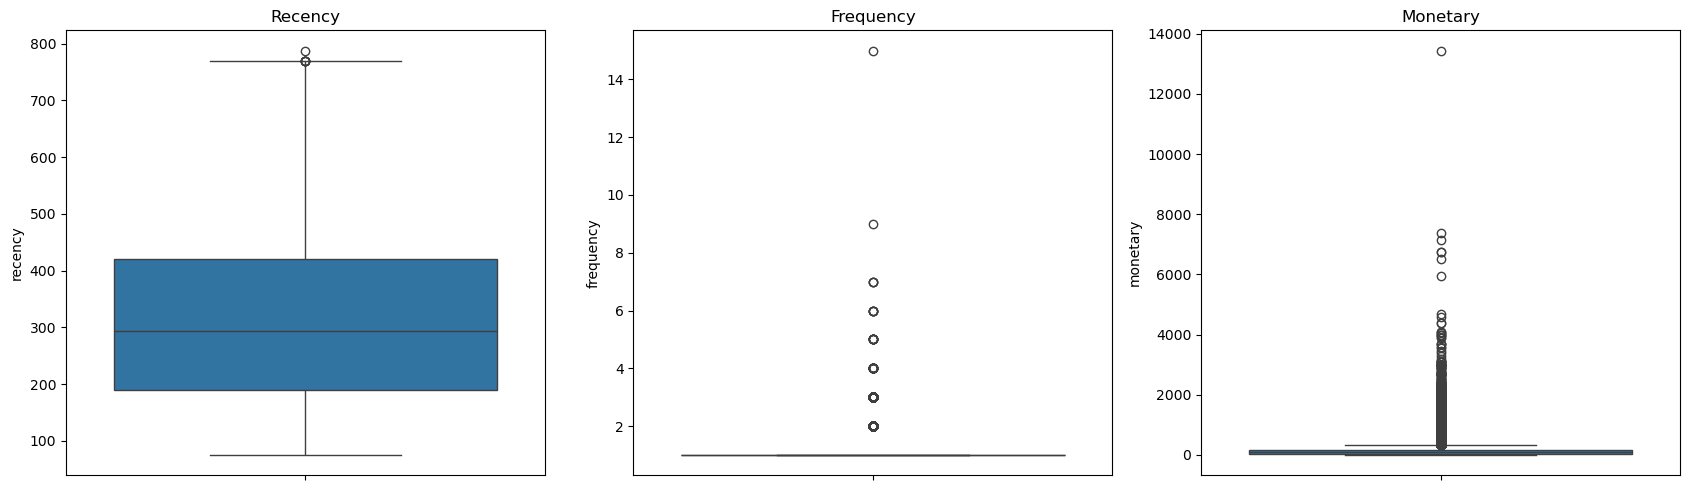

In [7]:
# Check for "outliers"
# Description analysis
rmf_statistic = df_rmf_raw[['recency','frequency','monetary']].describe().reset_index()
print(rmf_statistic)

# Visualize outliers with a Boxplot
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_rmf_raw['recency'])
plt.title('Recency')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_rmf_raw['frequency'])
plt.title('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(y=df_rmf_raw['monetary'])
plt.title('Monetary')

plt.tight_layout()
plt.show()

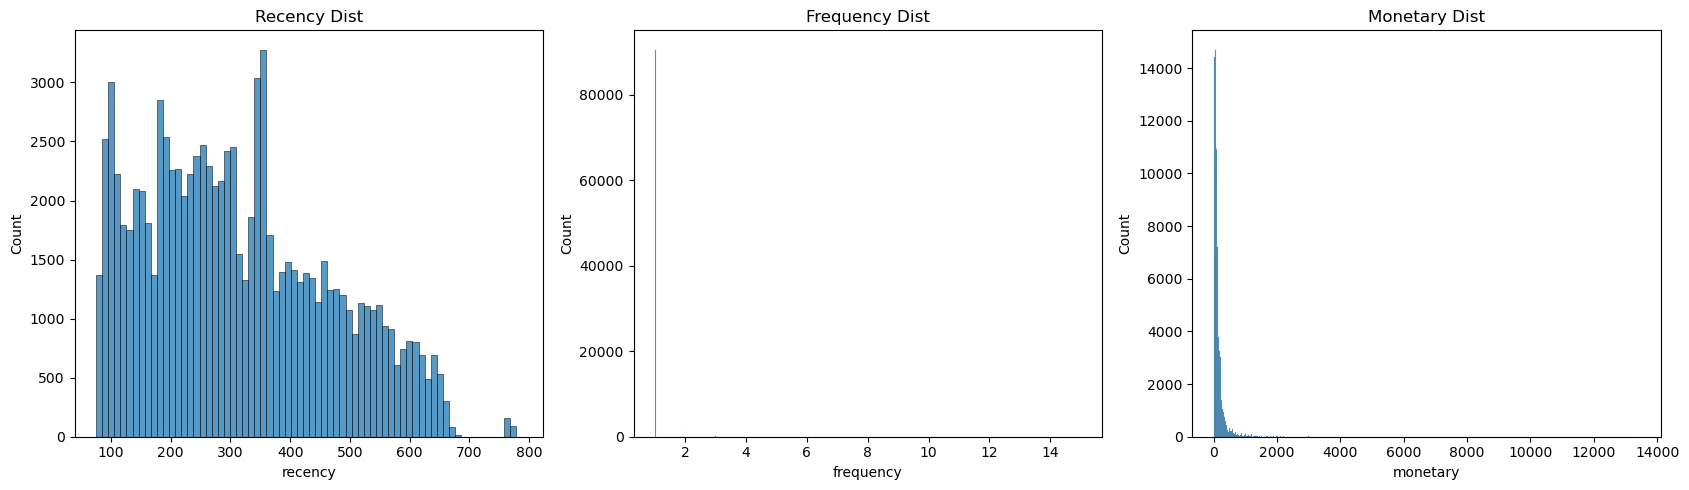

In [8]:
# Check distribution skewness
# Plot Histograms
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_rmf_raw['recency'])
plt.title('Recency Dist')

plt.subplot(1, 3, 2)
sns.histplot(df_rmf_raw['frequency'])
plt.title('Frequency Dist')

plt.subplot(1, 3, 3)
sns.histplot(df_rmf_raw['monetary'])
plt.title('Monetary Dist')

plt.tight_layout()
plt.show()

**Data Sanity check Result:**
- Over 97% of customers are one-time buyers. Frequency will be a weak differentiator for most segments, and the analysis will rely heavily on Recency (Churn status) and Monetary (Order size).
- Outliers: required log transformation
    - `frequency`: any >1 can be considered outliers.
    - `monetary`: there're an extreme value of $13,440.
- Data distribution: 
    - `recency` is the most evenly distributed variable while `monetary` and `frequency` is heavily right-skewed. However `recency` reflects the steady acquisition of customers over the 2-year period.


### 2.3 Data Processing for K-Means
1. Handle Zero/Negative values (if any).
    - `recency`: replace 0 value with 1
    - `frequency`: unlikely to appear in the df.
    - `monetary`: filter out $0 value orders. 
2. Apply log transformation 
3. Standardize the Scale

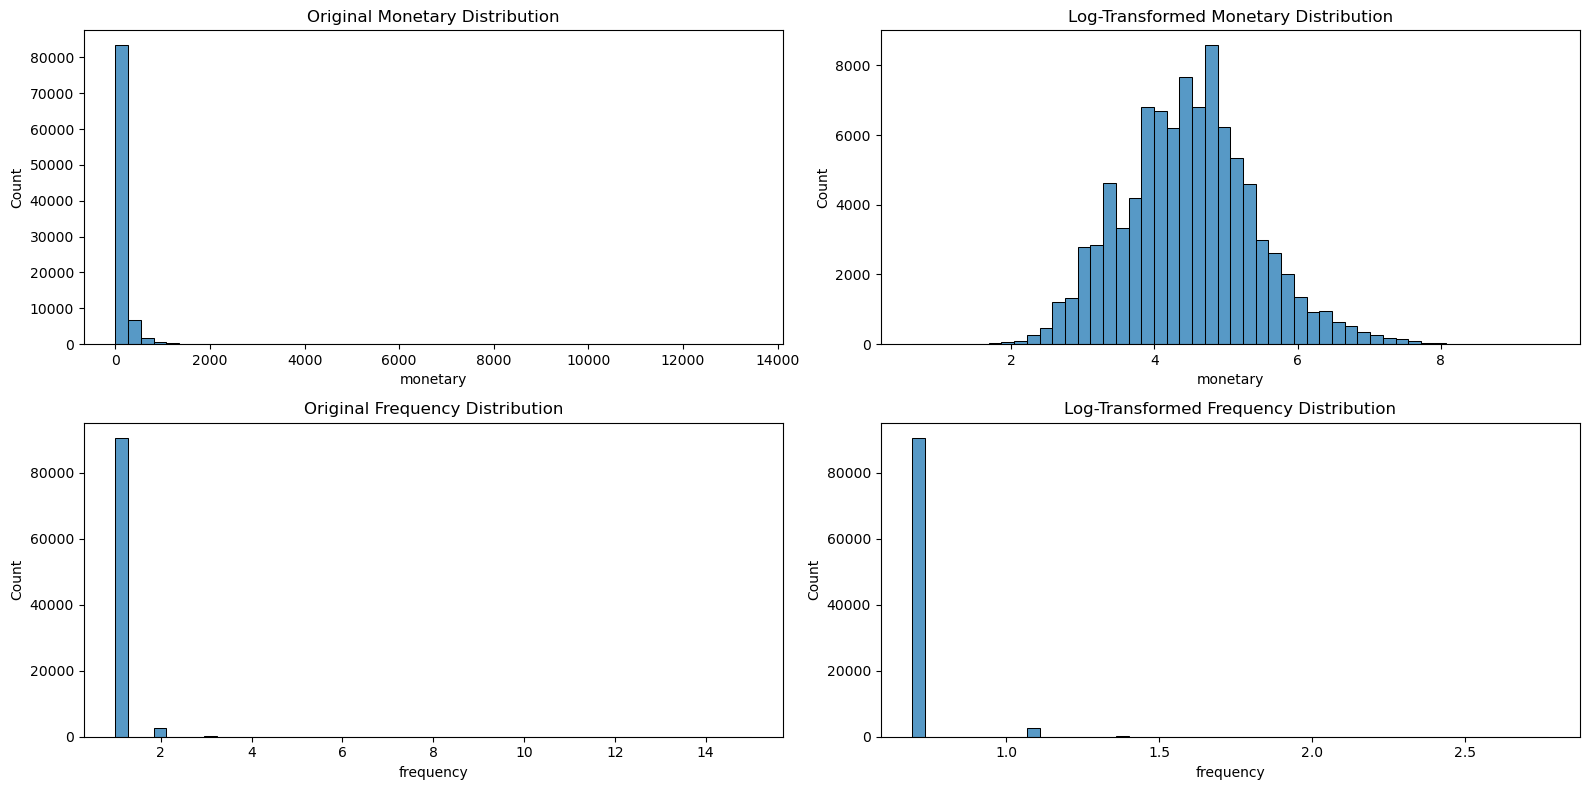

In [9]:
# Exclude any "$0 value orders"
df_rmf = df_rmf_raw.copy()
df_rmf = df_rmf[df_rmf['monetary']> 0 ]

# Replace "0" value with "1" in `recency`
df_rmf['recency'] = df_rmf['recency'].replace(0,1)

# Apply log transformation for the whole df 
df_rmf_log = np.log1p(df_rmf[['recency','frequency','monetary']])

# Visulize "Before" and "After" transformation 
plt.figure(figsize=(16,8))

# Before & After of 'Monetary'
plt.subplot(2, 2, 1)
sns.histplot(df_rmf['monetary'], bins=50)
plt.title('Original Monetary Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df_rmf_log['monetary'], bins=50)
plt.title('Log-Transformed Monetary Distribution')

# # Before & After of 'Frequecy'
plt.subplot(2, 2, 3)
sns.histplot(df_rmf['frequency'], bins=50)
plt.title('Original Frequency Distribution')

plt.subplot(2, 2, 4)
sns.histplot(df_rmf_log['frequency'], bins=50)
plt.title('Log-Transformed Frequency Distribution')

plt.tight_layout()
plt.show()

In [10]:
# Standard Scaling (Z-Score Normalization)
scaler = StandardScaler()
rmf_scaled = scaler.fit_transform(df_rmf_log)

# Convert back to DataFrame for readability
df_rmf_scaled = pd.DataFrame(rmf_scaled, columns=['recency', 'frequency', 'monetary'])

print("Data Scaled and Ready for Clustering:")
display(df_rmf_scaled.head())

Data Scaled and Ready for Clustering:


,recency,frequency,monetary
0,1.951085,-0.170197,0.462043
1,1.908481,-0.170197,-1.466857
2,1.908481,-0.170197,-0.933074
3,1.908481,-0.170197,0.334838
4,1.908481,-0.170197,-1.139261


## 3. Finding 'K' clusters (Elbow Method)

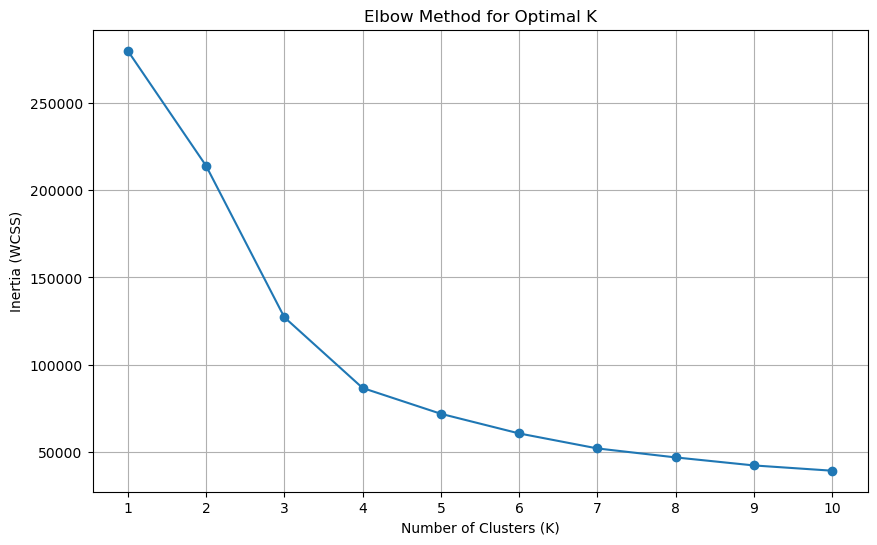

In [11]:
# Create a list of inertia and k values list to loop
inertia = []
k_range = range(1,11)

for k in k_range:
    # Initiate K-means 
    kmeans = KMeans(n_clusters=k,random_state=42)
    # Fit the model to the scaled data 
    kmeans.fit(df_rmf_scaled)
    # Append the inertia WCSS to the list 
    inertia.append(kmeans.inertia_)

# Plot the curve results
plt.figure(figsize=(10,6))
plt.plot(k_range,inertia,marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()





**Conclusion:**
Based on 'Elbow chart', the slope starts to flatten out at K=4 and K=5. For the current stage of the business, we decided to build the model K-Cluster with **K=5**.

## 4. Building the K-Means Model

In [17]:
# 1. Initialize K-Means with K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# 2. Fit the model on the scaled data
kmeans.fit(df_rmf_scaled)

# 3. Assign the clusters to the original dataframe
# (We assign it to the non-scaled df so we can read the real dollar amounts later)
df_rmf['Cluster'] = kmeans.labels_

print("Clusters assigned. First 5 rows:")
display(df_rmf.head())

# 4. Check the size of each cluster
print("\nCluster Sizes:")
print(df_rmf['Cluster'].value_counts().sort_index())

Clusters assigned. First 5 rows:


,customer_unique_sk,last_purchase_timestamp,frequency,monetary,recency,Cluster
0,51316,2016-09-15 12:16:38,1,134.97,788,0
1,48357,2016-10-03 16:56:50,1,21.90,770,2
2,42548,2016-10-03 21:13:36,1,36.49,770,2
3,70233,2016-10-03 22:06:03,1,119.90,770,0
4,45802,2016-10-03 22:31:31,1,29.99,770,2



Cluster Sizes:
Cluster
0    32132
1    26488
2    31929
3     2801
Name: count, dtype: int64


In [18]:
# Group by Cluster and calculate averages
cluster_summary = df_rmf.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_unique_sk': 'count' # To see how many people are in each
}).reset_index()

# Rename count column for clarity
cluster_summary = cluster_summary.rename(columns={'customer_unique_sk': 'Num_Customers'})
cluster_summary['cluster_percentage'] = 100* cluster_summary['Num_Customers']/(cluster_summary['Num_Customers'].sum())

cluster_summary = cluster_summary.round(2)

print("Cluster Profiles:")
display(cluster_summary)


Cluster Profiles:


,Cluster,recency,frequency,monetary,Num_Customers,cluster_percentage
0,0,380.74,1.00,251.35,32132,34.42
1,1,145.14,1.00,113.47,26488,28.37
2,2,384.18,1.00,44.16,31929,34.20
3,3,294.81,2.11,260.05,2801,3.00


In [29]:
# Name the Cluster 
cluster_name = {0:'Lost Whales',
                2:'Churned',
                1:'Recent New acquisition',
                3:'Loyalist'}

df_rmf['Segment_name'] = df_rmf['Cluster'].map(cluster_name)

# Save the static model to the database 
df_rmf.to_sql('analytics_static_segments', engine, if_exists='replace', index=False)
print("✅ Static K-Means segments saved to database.")

✅ Static K-Means segments saved to database.


### Save the Model and Pipeline


In [ ]:
# Save the Model and Pipeline
os.makedirs('models',exist_ok=True)
joblib.dump(kmeans, 'models/kmeans_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Model and Scaler saved to /models folder.")

## 5. Results and Conclusions


| Cluster   | Your Data Highlights                                | Segmentation        | Why? (The Insight) |
|-----------|-----------------------------------------------------|----------------------------------|---------------------|
| Cluster 3 | Freq: 2.11 (Highest)<br>Monetary: 260 (Highest)<br>Recency: 294 | **The "Loyalist"** (Only 3% of users) | Critical Insight: This is the only group that repeats orders. They spend the most and buy the most often. However, their Recency (294 days) is still high, meaning even your "best" customers haven't bought in ~10 months. They are loyal, but at risk. |
| Cluster 1 | Recency: 145 (Best)<br>Freq: 1.00<br>Monetary: 113 (Mid) | **"Recent New acquisition"** (28% of users) | These are your "Active" users. They bought ~5 months ago. They are the primary target for marketing because they are the "freshest" memory of the brand. Converting them to a 2nd purchase is the top priority. |
| Cluster 0 | Monetary: 251 (High)<br>Recency: 380 (Worst)<br>Freq: 1.00 | **"Lost Whales"** (34% of users) | Missed Opportunity. These people spent nearly as much as Loyalists ($251 vs $260) but only bought once and left over a year ago. They had high potential but the business failed to retain them. |
| Cluster 2 | Monetary: 44 (Lowest)<br>Recency: 384 (Worst)<br>Freq: 1.00 | **"Churned"** (34% of users) | Low Priority. They bought one cheap item long ago. It is likely not cost-effective to spend marketing budget trying to win them back. |

**Interpretation:**
- The market-place rely heavily on constantly acquisiting new customers rather than retaining current customers. 
- High recency in most customer groups suggest a short customer cycles.
- Recommendation: targeted marketing strategy to improve customer retention, relocate resources for "loyalists" and high spending customer such as the "Whales".

**Next project steps:**

## 6. Apply Scoring Systems for R-M-F
For easier business logic and visualization.

In [19]:
df_rmf

,customer_unique_sk,last_purchase_timestamp,frequency,monetary,recency,Cluster
0,51316,2016-09-15 12:16:38,1,134.97,788,0
1,48357,2016-10-03 16:56:50,1,21.90,770,2
2,42548,2016-10-03 21:13:36,1,36.49,770,2
3,70233,2016-10-03 22:06:03,1,119.90,770,0
4,45802,2016-10-03 22:31:31,1,29.99,770,2
...,...,...,...,...,...,...
93345,86164,2018-08-29 12:25:59,1,63.90,75,1
93346,86817,2018-08-29 14:18:23,1,418.00,75,1
93347,42012,2018-08-29 14:18:28,1,45.90,75,1
93348,28178,2018-08-29 14:52:00,1,24.90,75,1


In [28]:
df = df_rmf.copy()
# Recency & Monetary: Use Standard Quintiles to determine the score
df['r_score'] = pd.qcut(df['recency'], q=5, labels=[1, 2, 3, 4, 5])

# Create 'M_Score' from the 'Monetary' column
df['m_score'] = pd.qcut(df['monetary'], q=5, labels=[5, 4, 3, 2, 1])

# Define your function for Frequency
def get_f_score(x):
    if x == 1: return 1
    elif x == 2: return 3
    else: return 5

# Apply that function to the 'Frequency' column
df['f_score'] = df['frequency'].apply(get_f_score)

# Combine the scoring
df['rmf_score'] = df['r_score'].astype(str) + df['m_score'].astype(str) + df['f_score'].astype(str)

# Drop the uncessary columns

# View the first 5 rows of your updated DataFrame
print(df.head())

   customer_unique_sk last_purchase_timestamp  frequency  monetary  recency  \
0               51316     2016-09-15 12:16:38          1    134.97      788   
1               48357     2016-10-03 16:56:50          1     21.90      770   
2               42548     2016-10-03 21:13:36          1     36.49      770   
3               70233     2016-10-03 22:06:03          1    119.90      770   
4               45802     2016-10-03 22:31:31          1     29.99      770   

   Cluster r_score m_score  f_score  
0        0       5       2        1  
1        2       5       5        1  
2        2       5       5        1  
3        0       5       2        1  
4        2       5       5        1  
